## Introduction

A common problem encountered when trying to collect a set of publications from multiple researchers (e.g. a network of researchers working on a similar topic or using a shared facility) is the manual labor required to identify and vet the publications. A typical work flow in carrying out this task is for one or more people to search for publications (e.g. in Google Scholar) and then manually inspect each one to determine relevance. The search component of this process can be automated but, depending on the input available (e.g. the search terms used in the query), it may return a significant number of false positives. The manual labor needed to vet each publication is still too high to be practical. Two questions that will be explored below are: How accurate are the automated searchers? and Can the manual labor needed to vet the publications be reduced?

To explore these questions we will use a set of publications from the Critical Zone Observatory (CZO) website (https://czo-archive.criticalzone.org/reynolds/publications/). The DOIs for the publications were scraped from the sight and used to harvest clean publication records from Dimensions.

## Dependencies 

In [3]:
import csv, fasttext, math, os, random, sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Markdown, display
from matplotlib_venn import venn2, venn2_circles
# Need to add to the path to import local files
sys.path.insert(1, '../../../')
import helper
sys.path.insert(1, '../../../../')
import config

## Data

In [128]:
search_results = pd.read_csv('../data/train/not_relevant_publication.csv', header=0)

In [3]:
print(search_results.columns)

Index(['Unnamed: 0', 'label', 'title', 'authors', 'dimensions_id', 'doi',
       'doi_url', 'publisher', 'journal', 'volume', 'issue', 'pages',
       'pub_year', 'concepts', 'concepts_scores', 'category_bra',
       'category_for', 'provenance', 'pub_harvested_date'],
      dtype='object')


In [4]:
with open('../data/train/train.txt', 'r') as f:
    data = f.readlines()
    example_count = len(data)
    train_count = math.floor(example_count * .9)
    print(train_count)

with open('../data/train/train.train', 'w') as train:
    for i in data[train_count:]:
        train.write(i+'\n')

with open('../data/train/train.valid', 'w') as valid:
    for i in data[:train_count]:
        valid.write(i+'\n')

17914


## Intervention

Lets train a FastText model on 90% of the data.

In [5]:
model = fasttext.train_supervised(input='../data/train/train.train')

Now lets evaluate the model on the remaining 10%.

In [6]:
model.test('../data/train/train.valid')

(17914, 0.9464664508205872, 0.9464664508205872)

The outputs are the total number of publications (12,439), precision, and recall. Precision and recall are the same since there is only one label. With multiple labels, they would likely diverge. 95% is good. Its a decrease from the 98% achieved initially which is certainly due to the increased rigor behind gathering the training data; the trianing data is now harder because it includes publications that are more closely related. 

We should look at this as a proof of concept. It needs work before we can apply it in all instances where we need to collect a set of publications related to a shared facility or research network, but it is a promising start.

Now lets fold the test data into our model and use it to predict the relevance of our search results.

In [7]:
# Use all the training data we have
with open('../data/train/train.final', 'w') as final:
    for i in data:
        final.write(i+'\n')

final_model = fasttext.train_supervised(input='../data/train/train.final')

In [8]:
def predict_relevance(features):
    return str(final_model.predict(features)[0]).replace("'__label__", '').replace("',", '').replace('(', '').replace(')', '')

In [129]:
search_results = pd.read_csv('../data/search_results_with_categories.csv', header=0)

In [130]:
search_results.shape[0]

72854

In [ ]:
helper.plot_venn(reported_pubs['doi'], results_w_category['doi'], 'Reported Publication', 'Search Results (After Intervention)')

In [11]:
search_results.columns


Index(['title', 'authors', 'dimensions_id', 'doi', 'doi_url', 'publisher',
       'journal', 'volume', 'issue', 'pages', 'pub_year', 'concepts',
       'concepts_scores', 'category_bra', 'category_for', 'provenance',
       'query_term', 'pub_harvested_date'],
      dtype='object')

In [12]:
search_results['concepts'].replace('', np.nan, inplace=True)
search_results.dropna(subset=['concepts'], inplace=True)

In [13]:
search_results.shape[0]

68909

In [14]:
search_results['relevance'] = search_results.apply(lambda row : predict_relevance(str(row['concepts']).replace("['", "'").replace("']", "'").replace(", ", " ")), axis = 1)

In [15]:
search_results['relevance']

0        not-relevant
1            relevant
2        not-relevant
3        not-relevant
4        not-relevant
             ...     
72849    not-relevant
72850    not-relevant
72851    not-relevant
72852    not-relevant
72853    not-relevant
Name: relevance, Length: 68909, dtype: object

In [16]:
# Remove non-relevant publicaitons from the dataframe
search_results_filtered = search_results[~search_results.relevance.str.contains('not-relevant')]

In [17]:
search_results.shape

(68909, 19)

In [18]:
search_results_filtered.shape

(9738, 19)

In [4]:
# Load the reported publicaitons
reported_pubs = pd.read_csv('../data/reported_publications.csv')

Lets examine the consistency of the Dimensions 'concepts' field. Since this is what we are using to predict relevance, publications missing this field will not have accurate predictions.

In [5]:
reported_pubs.shape[0]

1070

In [6]:
reported_pubs['concepts'].replace('', np.nan, inplace=True)
reported_pubs.dropna(subset=['concepts'], inplace=True)

In [7]:
reported_pubs.shape[0]

1069

Fortunately only 1 publication in this data set is missing the 'concepts' field.

## Results & Discussion

Now lets plot our venn diagram again to see how well we did.

Total: 68353


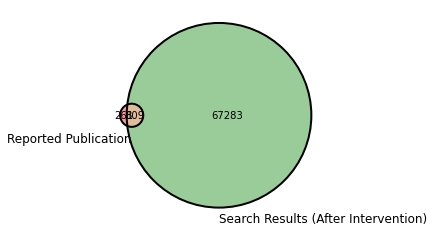

Precision: 0.01
Recall: 0.76


In [132]:
helper.plot_venn(reported_pubs['doi'], search_results['doi'], 'Reported Publication', 'Search Results (After Intervention)')

Total: 7266


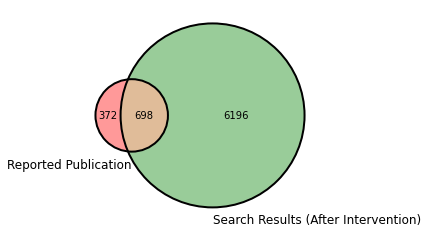

Precision: 0.1
Recall: 0.65


In [20]:
helper.plot_venn(reported_pubs['doi'], search_results_filtered['doi'], 'Reported Publication', 'Search Results (After Intervention)')

Thats a lot of publications to review. Lets compare this to our initial results:

Precision increased significantly but still not great but thats to be expected since we have optimized for maximum recall. Recall is 65% which is a significant increase from our previous score, which included only query terms with high correlation to the facility, of (35%), or (32%) after cleanup. However, its 11% lower than what was captured in the search results above. This is an area that we want to improve. Ideally we probably want to capture every publication possible and do the best we can to minimize the impact to the manual evaluation process.

In [22]:
final_doi_set = set(search_results_filtered['doi']) - set(reported_pubs['doi'])
print(len(final_doi_set))

6196


In [26]:
w = csv.writer(open("../data/search_resuts_filtered_dois.csv",'w'))
w.writerow(['doi'])
print(len(final_doi_set))
for i in final_doi_set:
        w.writerow([i])

6196


### Impact on Publicaiton Review Process

6,196 publications is a lot to review but its important to note that these are spread out over a long period of time. Let's take a look at some of the implications of that fact. 

In [79]:
print(f'Date range of reported publications: {reported_pubs.pub_year.min()}-{reported_pubs.pub_year.max()}')

Date range of reported publications: 1993-2021


The time range of the reported publications ranges from 1993 to 2021. Presumably we can clean up our dataset by filtering out publications with dates prior to 1993.

Lets look at the most recent years to see how many publications per year would need manual review.

<AxesSubplot:>

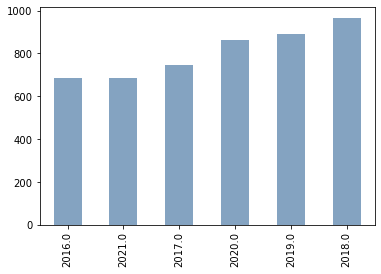

In [53]:
search_results_filtered.pub_year.where(search_results_filtered.pub_year > 2015).value_counts().dropna().astype(int).sort_values().plot(kind='bar', color=(0.2, 0.4, 0.6, 0.6))
                                                                                                                  

The largest number is under 1,000. This is not that bad especially if a larger percentage turn out to be relevant but unreported publications. 

Some terms may be so strongly associated with a domain that their presence in a publication is a certain indicator of relevance. What if we filter out all of the publications containing the proper noun phrase "Critical Zone Observator" (Observatory is shortened to catch plural and singular forms of the word).

<AxesSubplot:>

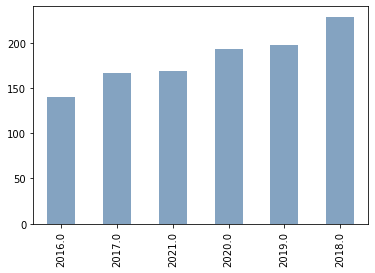

In [93]:
search_results_filtered.pub_year.where(search_results_filtered.query_term.str.contains("Critical Zone Observator")).where(search_results_filtered.pub_year > 2015).value_counts().sort_values().plot(kind='bar', color=(0.2, 0.4, 0.6, 0.6))


In [103]:
summary_data = pd.DataFrame()

In [104]:
summary_data['Reported'] = reported_pubs.pub_year.where(reported_pubs.pub_year > 2015).value_counts()

In [105]:
summary_data['Minimum Unreported'] = search_results_filtered.pub_year.where(search_results_filtered.query_term.str.contains("Critical Zone Observator")).where(search_results_filtered.pub_year > 2015).value_counts()

In [106]:
summary_data['Publications Returned'] = search_results_filtered.pub_year.where(search_results_filtered.pub_year > 2015).value_counts()

In [122]:
summary_data['Minimum Percent Unreported'] = ((summary_data['Minimum Unreported']/(summary_data['Reported']+summary_data['Minimum Unreported']))*100).astype(int)

In [124]:
summary_data['Minimum Precision of Alleged False Positives'] = ((summary_data['Minimum Unreported']/summary_data['Publications Returned'])*100).astype(int)

In [126]:
summary_data.index = summary_data.index.astype(int)

In [127]:
summary_data

,Reported,Minimum Unreported,Publications Returned,Minimum Percent Unreported,Minimum Precision of Alleged False Positives
2016,128,140,683,52,20
2017,116,167,746,59,22
2018,116,229,967,66,23
2019,96,198,891,67,22
2020,48,193,863,80,22
2021,1,169,684,99,24
